# Anomalies Detection using Heuristic Method

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from IPython.display import display, Math

In [39]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=np.ComplexWarning)

In [40]:
fourier_transform = r"""\boxed{\begin{array}{c}
\text{Fourier transform} \\[10pt]
\hat{f}(\xi) = \int_{-\infty}^{\infty} f(x) e^{-i 2 \pi \xi x} \, dx \quad
\end{array}}"""

display(Math(fourier_transform))


<IPython.core.display.Math object>

## Loading Data

In [41]:
data_path = "../data/raw/waterDataTraining.csv"
df = pd.read_csv(data_path)
df.head(5)

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,2016-08-03T09:49:00Z,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
1,2016-08-03T09:50:00Z,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2,2016-08-03T09:51:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
3,2016-08-03T09:52:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
4,2016-08-03T09:53:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False


Our function to preprocess data from before:

In [42]:
def data_preprocessing(df, columns_to_drop):
    processed_df = df.copy()
    processed_df['Time'] = pd.to_datetime(processed_df['Time'])
    processed_df.set_index('Time', inplace=True)
    processed_df.drop(columns=columns_to_drop, inplace=True)
    processed_df['pH'].interpolate(method='time', inplace=True)
    
    return processed_df

## Model: Fourier Transform

Here, we define the fourier transform and predict functions:

In [43]:
from numpy.fft import fft
from numpy.fft import ifft

def fourier_transform(df: pd.DataFrame, serie_name: str, k_sample=10):
    k_sample *= -1
    x_values = df[serie_name].values
    x_fft = fft(x_values)
    magnitudes = np.abs(x_fft) # computing the amplitude of each frequency
    significant_frequencies = np.argsort(magnitudes)[k_sample:]
    filtered_fft = np.copy(x_fft)
    filtered_fft[~np.isin(np.arange(len(filtered_fft)), significant_frequencies)] = 0

    return x_values, filtered_fft

def fourier_prediction(df: pd.DataFrame, x_values: pd.Series, filtered_fft: np.array, alpha=2):
    reconstructed_signal = ifft(filtered_fft) # inverse of fourier transform
    abs_deviation = np.abs(x_values - reconstructed_signal) # computing absolute deviation from original signal. If 0 no deviation.
    mean_deviation = np.mean(abs_deviation)
    std_deviation = np.std(abs_deviation)

    threshold = mean_deviation + alpha * std_deviation
    anomalies = np.abs(x_values - reconstructed_signal) > threshold # if our fourier values are above the defined threshold, they are anomalies
    df['FFT_Anomaly'] = anomalies

    return reconstructed_signal, anomalies, df


In [45]:
def fourier_evaluation(df: pd.DataFrame, y_true: str, y_pred: str):
    precision = precision_score(df[y_true], df[y_pred])
    recall = recall_score(df[y_true], df[y_pred])
    f1 = f1_score(df[y_true], df[y_pred])

    return precision, recall, f1

In [44]:
def plot_fft_anomalies(df, original_signal, reconstructed_signal, anomalies):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, original_signal, label='Original pH', color='blue')
    plt.plot(df.index, reconstructed_signal, label='Reconstructed pH', color='orange')
    plt.scatter(df.index[df['EVENT']], df['pH'][df['EVENT']], color='green', label='True Anomaly', zorder=5)
    plt.scatter(df.index[anomalies], original_signal[anomalies], facecolors='none', edgecolors='orange', label='Detected Anomaly', zorder=6)
    plt.legend()
    plt.title('Fourier Transform Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('pH')
    plt.show()

## Fourier Prediction in Action

In [46]:
columns_to_drop = ['Tp', 'Cl', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm','Fm_2']
processed_df = data_preprocessing(df, columns_to_drop)

/var/folders/x9/wfxfy30n21j10t1dqkkhfjjm0000gn/T/ipykernel_3634/4268277382.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['pH'].interpolate(method='time', inplace=True)


In order to have an idea of how well our model can perform based on the hyper-parameters settings, we will perform a few iterations on different values for k_samples and alpha.

For k_samples from 10 to 30:

------------------------------------------------------------------------------------------------------------------------
K: 10, Precision: 0.8853383458646616
------------------------------------------------------------------------------------------------------------------------


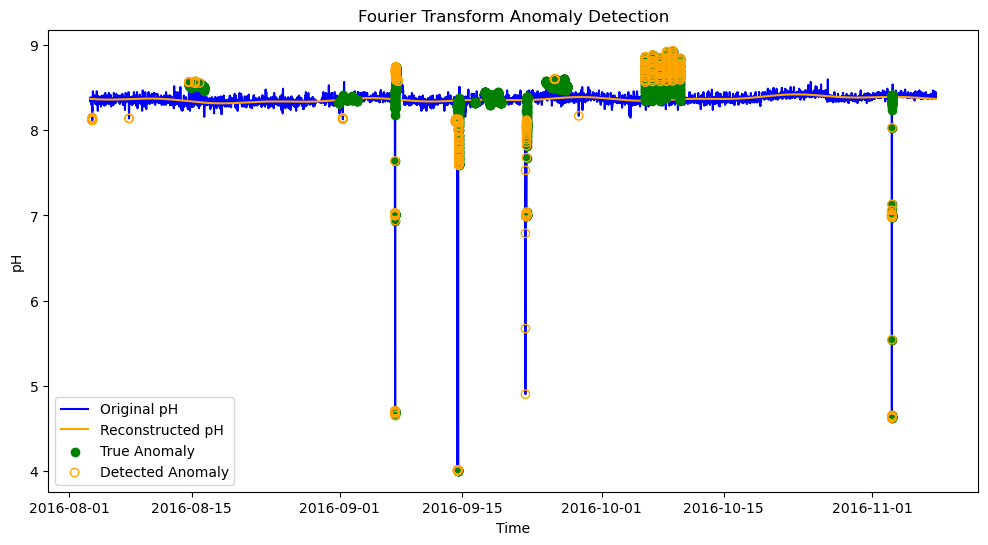

------------------------------------------------------------------------------------------------------------------------
K: 20, Precision: 0.9325842696629213
------------------------------------------------------------------------------------------------------------------------


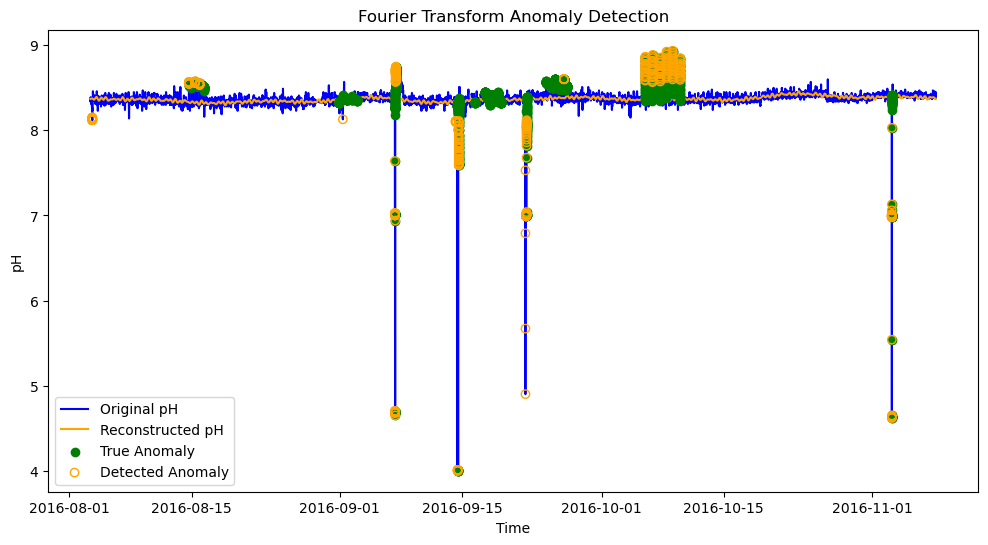

------------------------------------------------------------------------------------------------------------------------
K: 30, Precision: 0.948051948051948
------------------------------------------------------------------------------------------------------------------------


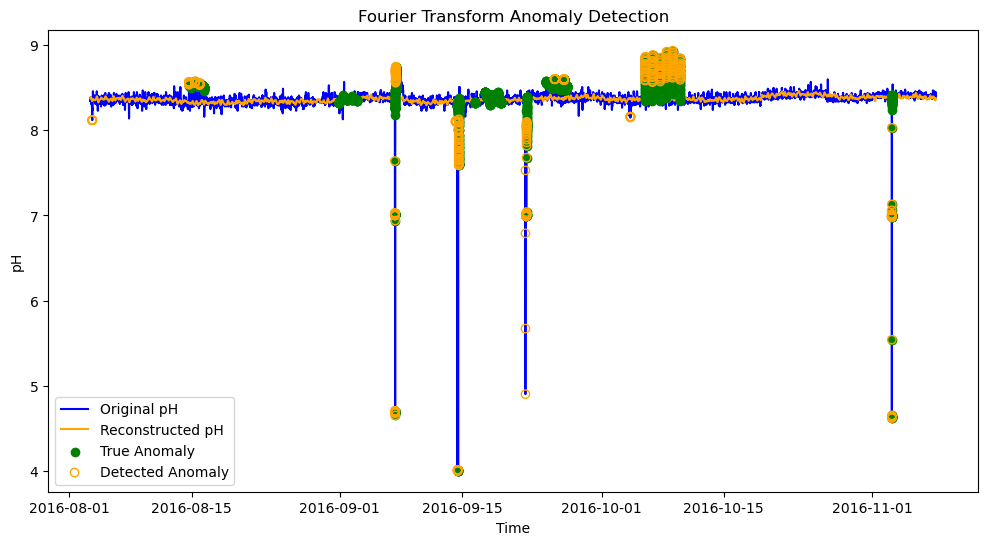

   k_value  Precision    Recall  F1_Score
0       10   0.885338  0.272885  0.417183
1       20   0.932584  0.288528  0.440708
2       30   0.948052  0.296060  0.451214


In [47]:
results = []
k_samples = [10, 20, 30]

for k in k_samples:
    ph_values, filtered_fft = fourier_transform(processed_df, 'pH', k_sample=k)
    reconstructed_signal, anomalies, data = fourier_prediction(processed_df, x_values=ph_values, filtered_fft=filtered_fft, alpha=2)
    precision, recall, f1 = fourier_evaluation(data, 'EVENT', 'FFT_Anomaly')
    results.append((k, precision, recall, f1))
    print("----"*30)
    print(f"K: {k}, Precision: {precision}")
    print("----"*30)
    plot_fft_anomalies(data, original_signal=ph_values, reconstructed_signal=reconstructed_signal, anomalies=anomalies)

results_df = pd.DataFrame(results, columns=['k_value', 'Precision', 'Recall', 'F1_Score'])
print(results_df)

Precision is quite astonishing! However, we can see the recall is pretty low for only 10 samples. With more, our recall score is increasing. 
Before running more test let's see how it performs when playing with the alpha value:

------------------------------------------------------------------------------------------------------------------------
Alpha: 1.6, Precision: 0.6676646706586826
------------------------------------------------------------------------------------------------------------------------


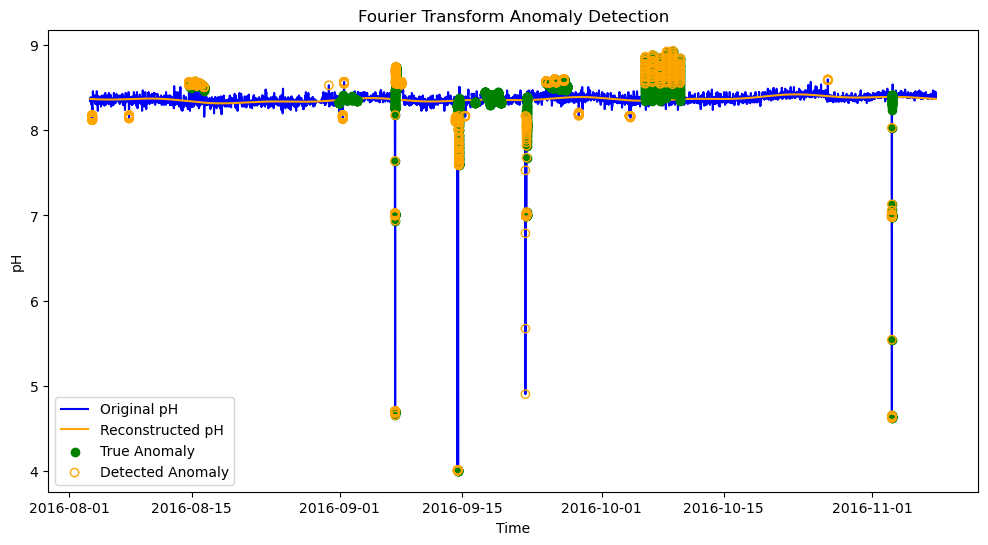

------------------------------------------------------------------------------------------------------------------------
Alpha: 1.8, Precision: 0.7896825396825397
------------------------------------------------------------------------------------------------------------------------


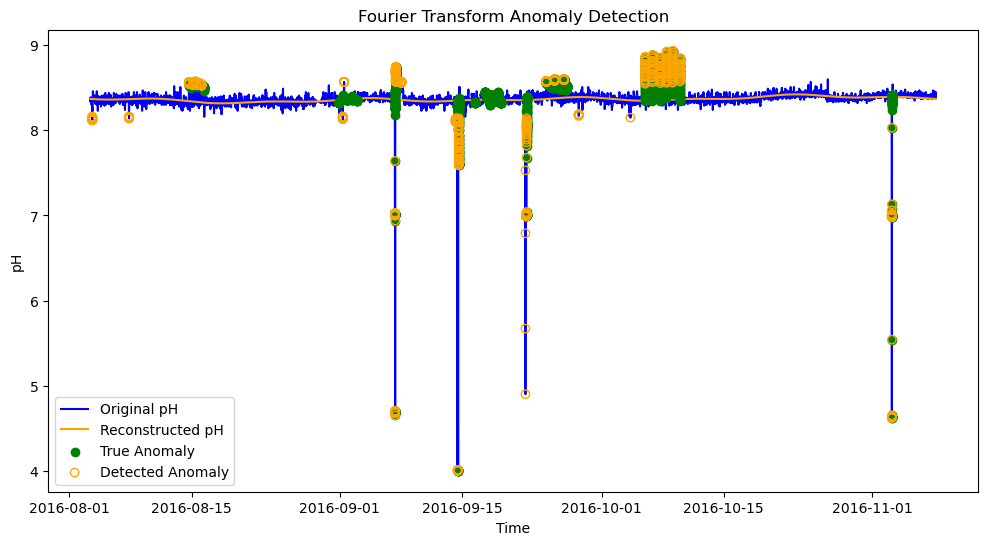

------------------------------------------------------------------------------------------------------------------------
Alpha: 2, Precision: 0.8853383458646616
------------------------------------------------------------------------------------------------------------------------


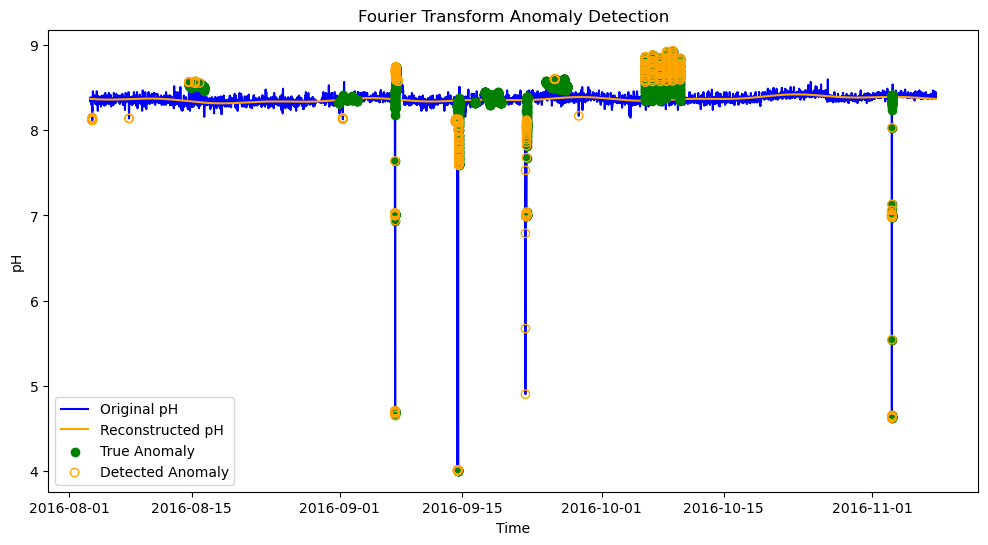

------------------------------------------------------------------------------------------------------------------------
Alpha: 2.2, Precision: 0.9423503325942351
------------------------------------------------------------------------------------------------------------------------


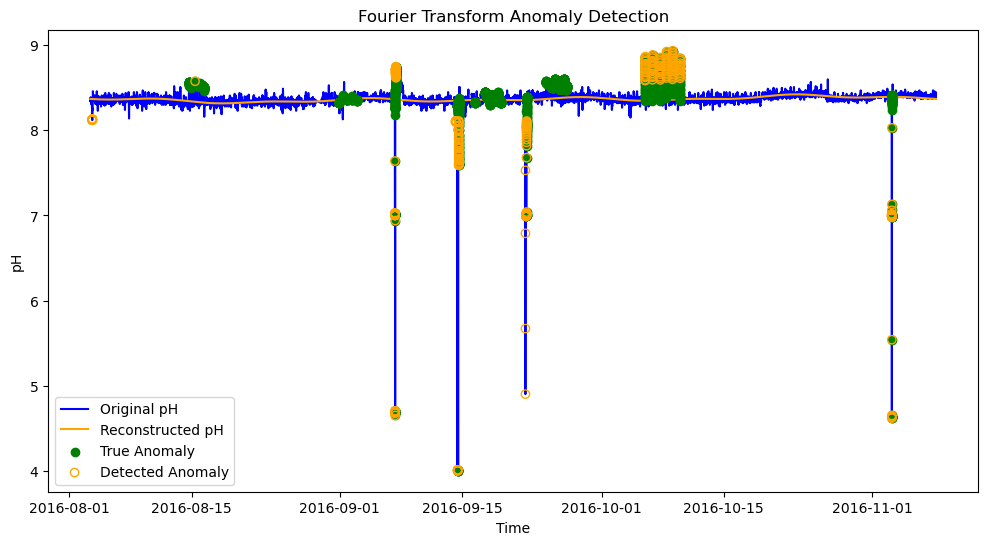

------------------------------------------------------------------------------------------------------------------------
Alpha: 2.4, Precision: 0.9904534606205251
------------------------------------------------------------------------------------------------------------------------


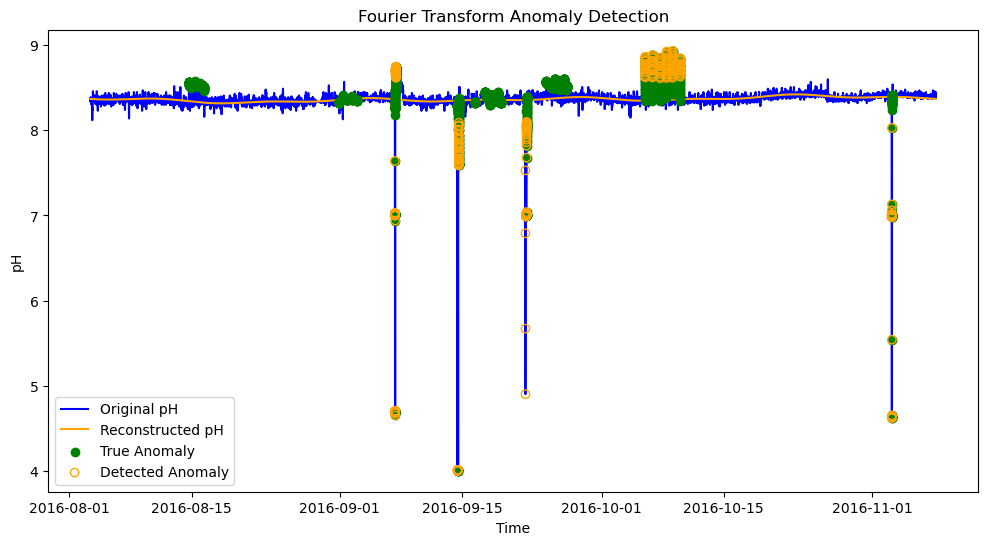

   alpha_value  Precision    Recall  F1_Score
0          1.6   0.667665  0.387601  0.490469
1          1.8   0.789683  0.345886  0.481064
2          2.0   0.885338  0.272885  0.417183
3          2.2   0.942350  0.246234  0.390446
4          2.4   0.990453  0.240440  0.386946


In [48]:
results = []
k=10
alphas = [1.6, 1.8, 2, 2.2, 2.4]

for value in alphas:
    ph_values, filtered_fft = fourier_transform(processed_df, 'pH', k_sample=k)
    reconstructed_signal, anomalies, data = fourier_prediction(processed_df, x_values=ph_values, filtered_fft=filtered_fft, alpha=value)
    precision, recall, f1 = fourier_evaluation(data, 'EVENT', 'FFT_Anomaly')
    results.append((value, precision, recall, f1))
    print("----"*30)
    print(f"Alpha: {value}, Precision: {precision}")
    print("----"*30)
    plot_fft_anomalies(data, original_signal=ph_values, reconstructed_signal=reconstructed_signal, anomalies=anomalies)

results_df = pd.DataFrame(results, columns=['alpha_value', 'Precision', 'Recall', 'F1_Score'])
print(results_df)

As alpha impacts our threshold, making it less or more strict, we naturally observe an impact on the precision. However, if higher values for alpha drastically improve the precision, our recall is suffering from this. So maybe we should try both at once?

------------------------------------------------------------------------------------------------------------------------
Precision for alpha = 1.6 and k = 5: 0.6816326530612244
------------------------------------------------------------------------------------------------------------------------


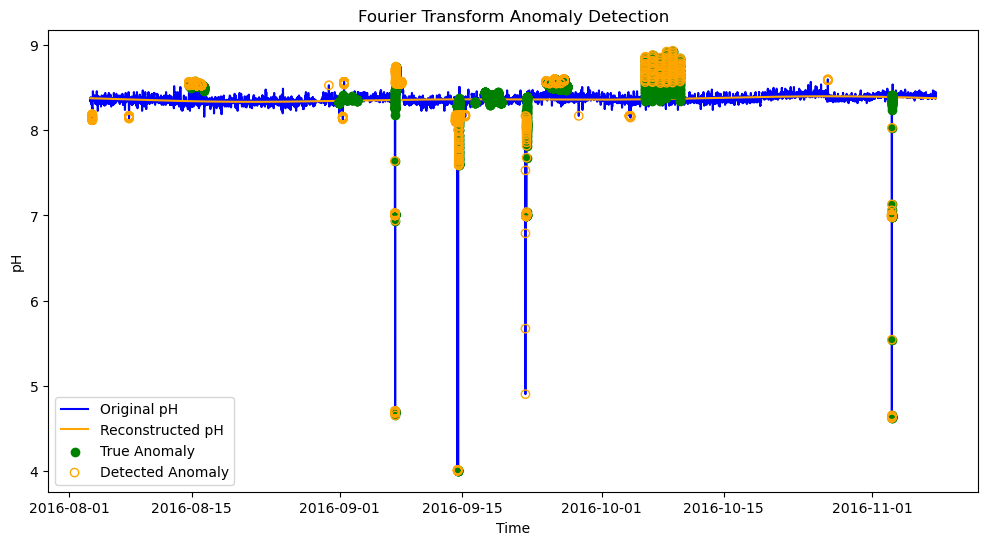

------------------------------------------------------------------------------------------------------------------------
Precision for alpha = 1.8 and k = 10: 0.7896825396825397
------------------------------------------------------------------------------------------------------------------------


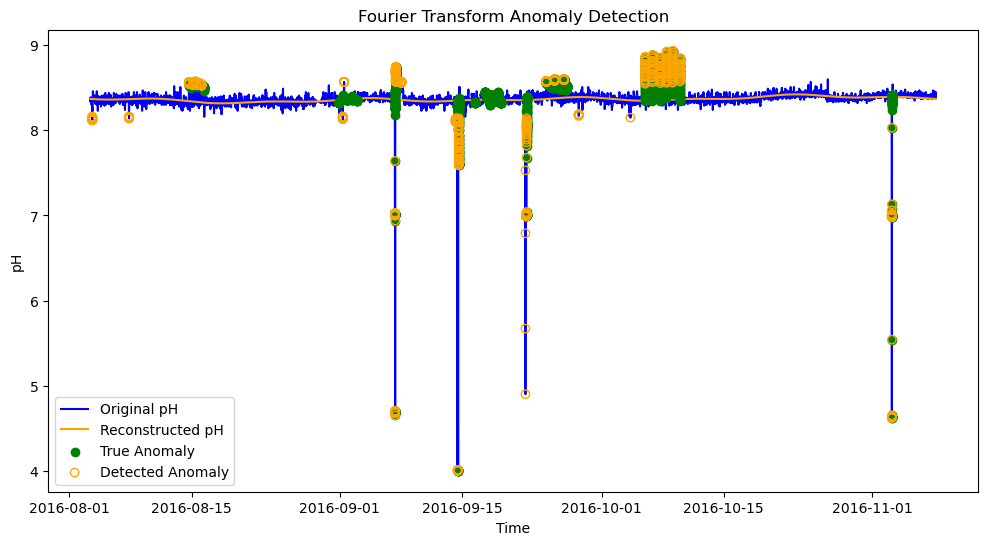

------------------------------------------------------------------------------------------------------------------------
Precision for alpha = 2 and k = 15: 0.9238095238095239
------------------------------------------------------------------------------------------------------------------------


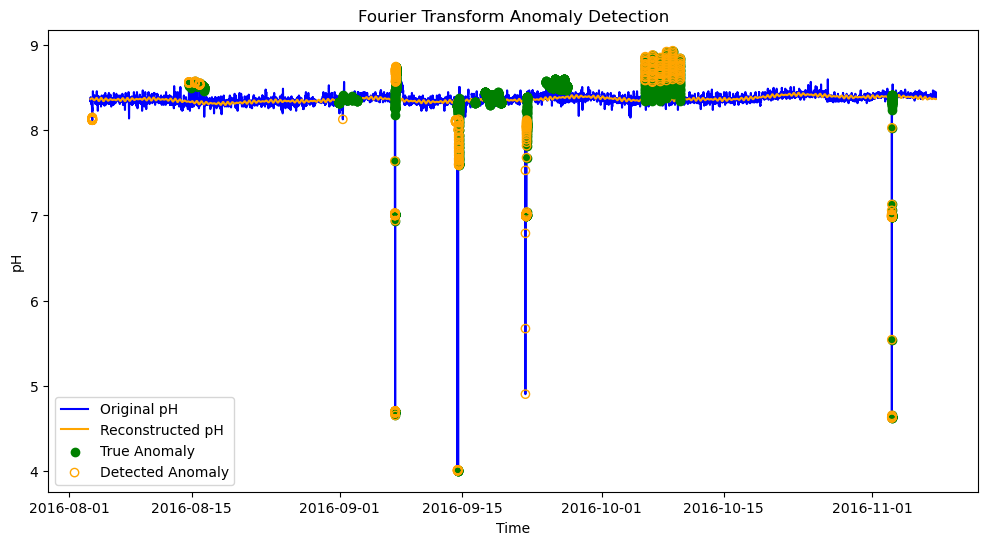

------------------------------------------------------------------------------------------------------------------------
Precision for alpha = 2.2 and k = 25: 0.973741794310722
------------------------------------------------------------------------------------------------------------------------


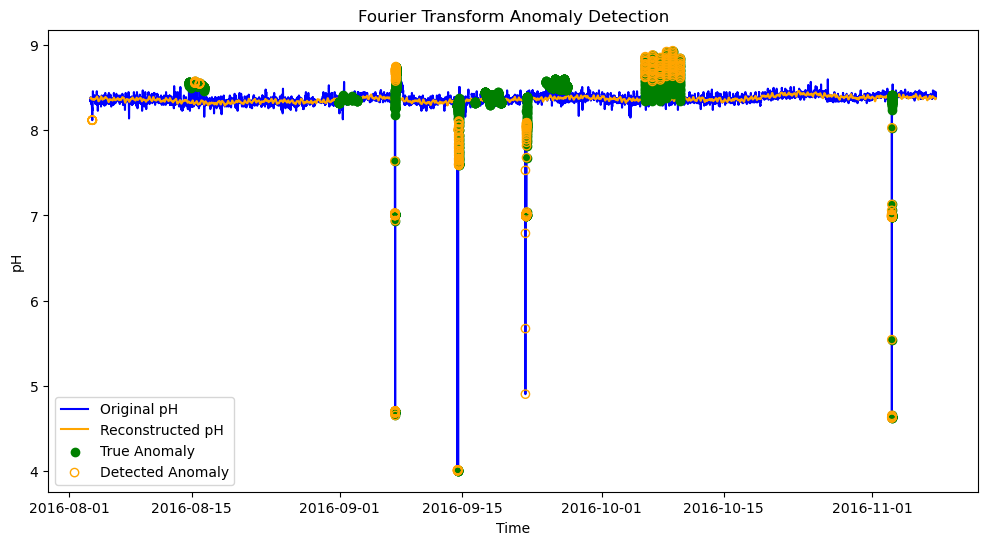

------------------------------------------------------------------------------------------------------------------------
Precision for alpha = 2.4 and k = 30: 0.9905660377358491
------------------------------------------------------------------------------------------------------------------------


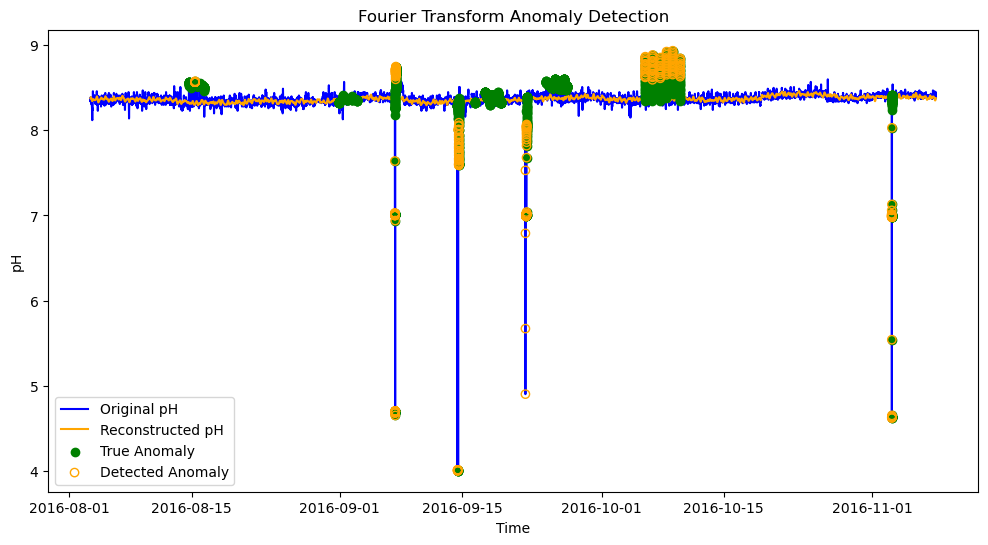

    k  alpha  Precision    Recall  F1_Score
0   5    1.6   0.681633  0.387022  0.493718
1  10    1.8   0.789683  0.345886  0.481064
2  15    2.0   0.923810  0.280997  0.430920
3  25    2.2   0.973742  0.257822  0.407696
4  30    2.4   0.990566  0.243337  0.390698


In [49]:
results = []
k=[5,10,15,25,30]
alphas = [1.6, 1.8, 2, 2.2, 2.4]

for i in range(len(k)):
    ph_values, filtered_fft = fourier_transform(processed_df, 'pH', k_sample=k[i])
    reconstructed_signal, anomalies, data = fourier_prediction(processed_df, x_values=ph_values, filtered_fft=filtered_fft, alpha=alphas[i])
    precision, recall, f1 = fourier_evaluation(data, 'EVENT', 'FFT_Anomaly')
    results.append((k[i], alphas[i], precision, recall, f1))
    print("----"*30)
    print(f"Precision for alpha = {alphas[i]} and k = {k[i]}: {precision}")
    print("----"*30)
    plot_fft_anomalies(data, original_signal=ph_values, reconstructed_signal=reconstructed_signal, anomalies=anomalies)

results_df = pd.DataFrame(results, columns=['k', 'alpha', 'Precision', 'Recall', 'F1_Score'])
print(results_df)

Extending the number of included k_samples and alpha at the same time did not really help. But maybe we could try to combine the two ideas by increasing the number of included samples, and set an alpha value between 1.5 and 2:

------------------------------------------------------------------------------------------------------------------------
Precision for alpha = 1.4 and k = 10: 0.5843653250773994
------------------------------------------------------------------------------------------------------------------------


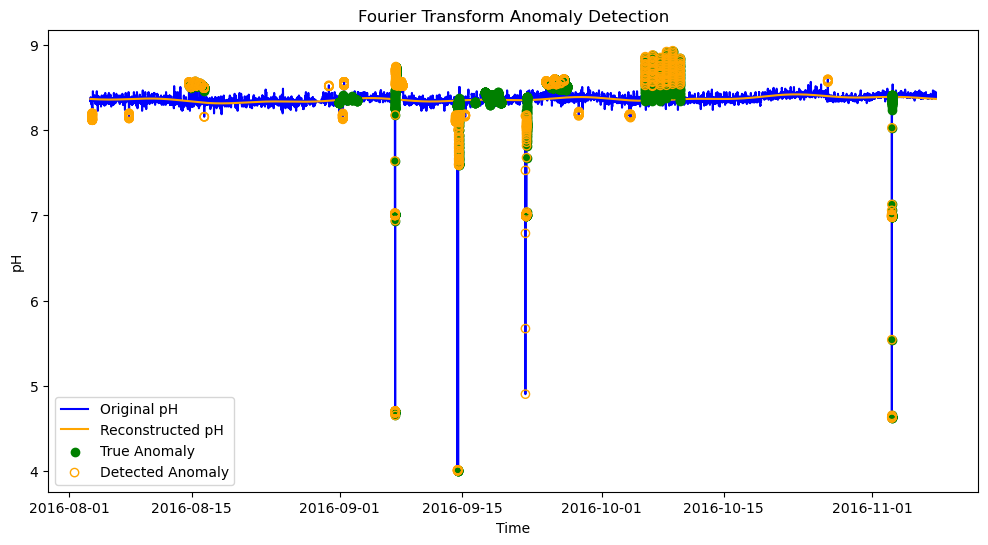

------------------------------------------------------------------------------------------------------------------------
Precision for alpha = 1.6 and k = 15: 0.6798418972332015
------------------------------------------------------------------------------------------------------------------------


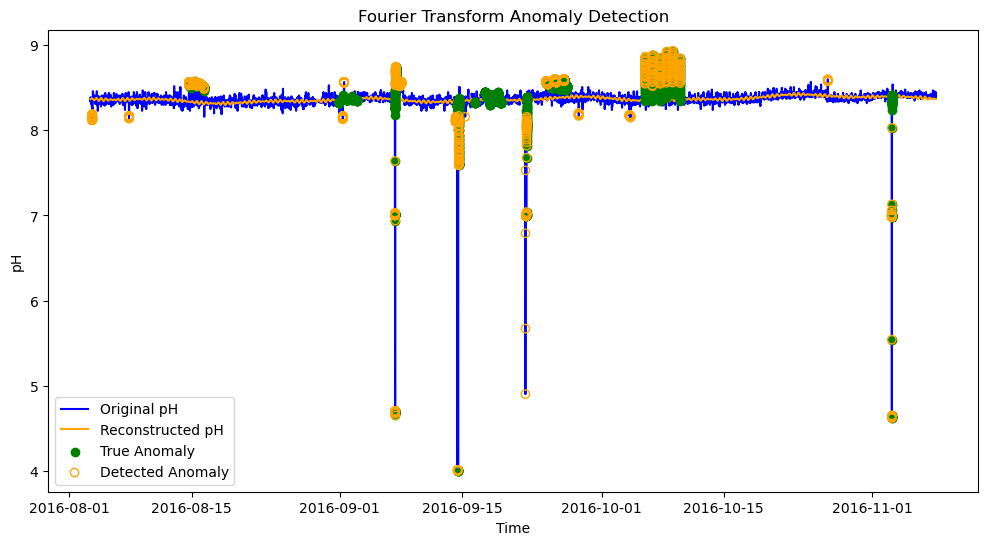

------------------------------------------------------------------------------------------------------------------------
Precision for alpha = 1.8 and k = 20: 0.8227474150664698
------------------------------------------------------------------------------------------------------------------------


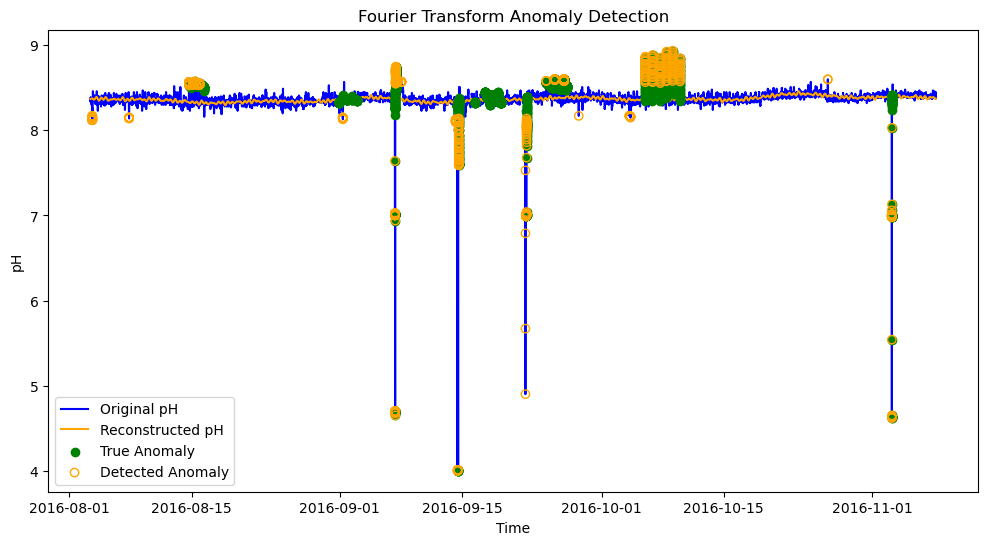

------------------------------------------------------------------------------------------------------------------------
Precision for alpha = 2 and k = 30: 0.948051948051948
------------------------------------------------------------------------------------------------------------------------


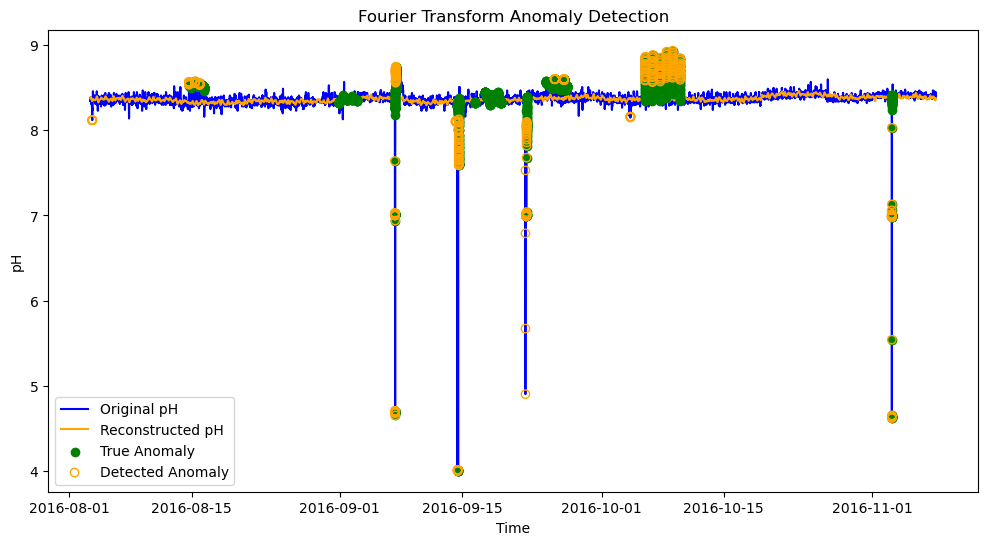

    k  alpha  Precision    Recall  F1_Score
0  10    1.4   0.584365  0.437428  0.500331
1  15    1.6   0.679842  0.398610  0.502557
2  20    1.8   0.822747  0.322711  0.463587
3  30    2.0   0.948052  0.296060  0.451214


In [50]:
results = []
k=[10, 15, 20, 30]
alphas = [1.4, 1.6, 1.8, 2]

for i in range(len(k)):
    ph_values, filtered_fft = fourier_transform(processed_df, 'pH', k_sample=k[i])
    reconstructed_signal, anomalies, data = fourier_prediction(processed_df, x_values=ph_values, filtered_fft=filtered_fft, alpha=alphas[i])
    precision, recall, f1 = fourier_evaluation(data, 'EVENT', 'FFT_Anomaly')
    results.append((k[i], alphas[i], precision, recall, f1))
    print("----"*30)
    print(f"Precision for alpha = {alphas[i]} and k = {k[i]}: {precision}")
    print("----"*30)
    plot_fft_anomalies(data, original_signal=ph_values, reconstructed_signal=reconstructed_signal, anomalies=anomalies)

results_df = pd.DataFrame(results, columns=['k', 'alpha', 'Precision', 'Recall', 'F1_Score'])
print(results_df)

In [56]:
results = []
k=[10, 15, 20, 30, 40, 50, 60, 70, 80]
a = [1.2, 1.4, 1.6, 1.8, 2.0]

for i in range(len(k)):
    for j in range(len(a)):
        ph_values, filtered_fft = fourier_transform(processed_df, 'pH', k_sample=k[i])
        reconstructed_signal, anomalies, data = fourier_prediction(processed_df, x_values=ph_values, filtered_fft=filtered_fft, alpha=a[j])
        precision, recall, f1 = fourier_evaluation(data, 'EVENT', 'FFT_Anomaly')
        results.append((k[i], a[j], precision, recall, f1))

results_df = pd.DataFrame(results, columns=['k', 'alpha', 'Precision', 'Recall', 'F1_Score'])
print(results_df)

     k  alpha  Precision    Recall  F1_Score
0   10    1.2   0.464409  0.468714  0.466551
1   10    1.4   0.584365  0.437428  0.500331
2   10    1.6   0.667665  0.387601  0.490469
3   10    1.8   0.789683  0.345886  0.481064
4   10    2.0   0.885338  0.272885  0.417183
5   15    1.2   0.475202  0.477404  0.476301
6   15    1.4   0.585008  0.438586  0.501325
7   15    1.6   0.679842  0.398610  0.502557
8   15    1.8   0.803863  0.313441  0.451021
9   15    2.0   0.923810  0.280997  0.430920
10  20    1.2   0.493001  0.469293  0.480855
11  20    1.4   0.613837  0.442063  0.513978
12  20    1.6   0.720619  0.404983  0.518546
13  20    1.8   0.822747  0.322711  0.463587
14  20    2.0   0.932584  0.288528  0.440708
15  30    1.2   0.545336  0.484357  0.513041
16  30    1.4   0.638169  0.428158  0.512483
17  30    1.6   0.750831  0.392816  0.515785
18  30    1.8   0.832599  0.328505  0.471126
19  30    2.0   0.948052  0.296060  0.451214
20  40    1.2   0.541447  0.476825  0.507086
21  40    

As we can see, a choice must be made between the Precision and the Recall with the Fourier Transform method. Increasing together the number of top samples to be included and the value for alpha does not necessarily result in a better recall. 

It seems the Fourier Transform method is very efficient at spotting anomalies on a given dataset, but kind of failing to generalize in case of unbalanced classes dataset like ours. Here, as we are talking about water quality, Fourier might not be the most approriate model as missing an anomaly could have dramatic outcomes. 

However, if  we look again at the graph, we will notice the false negative from Fourier are data points that are still very afar from the rest of the series. Which makes sense as the Fourier Transform will calculate the magnitude of our values. 

------------------------------------------------------------------------------------------------------------------------
K: 30, Alpha: 2.0, Precision: 0.948051948051948, Recall: 0.29606025492468135, F1 Score: 0.4512141280353201
------------------------------------------------------------------------------------------------------------------------


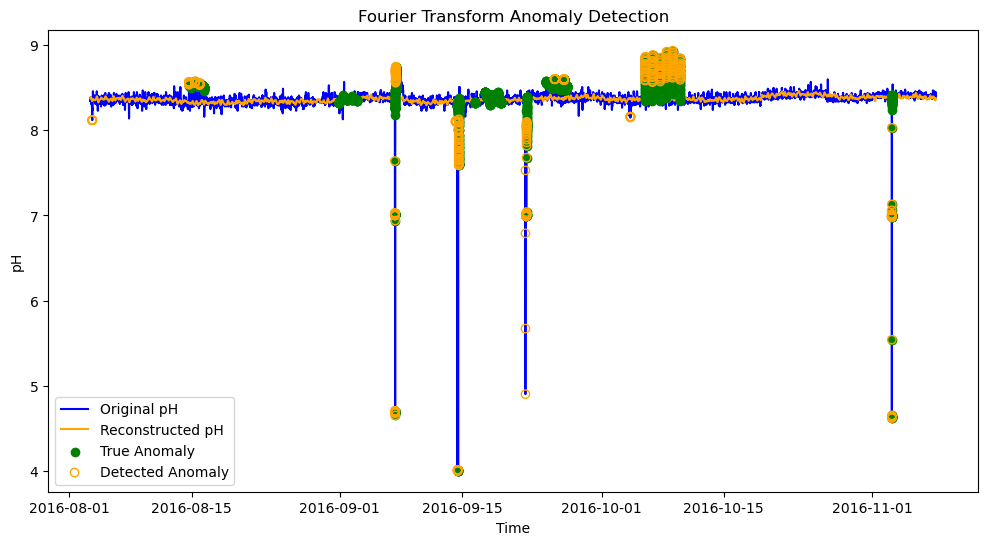

In [58]:
ph_values, filtered_fft = fourier_transform(processed_df, 'pH', k_sample=30)
reconstructed_signal, anomalies, data = fourier_prediction(processed_df, x_values=ph_values, filtered_fft=filtered_fft, alpha=2.0)
precision, recall, f1 = fourier_evaluation(data, 'EVENT', 'FFT_Anomaly')
results.append((value, precision, recall, f1))
print("----"*30)
print(f"K: {30}, Alpha: {2.0}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
print("----"*30)
plot_fft_anomalies(data, original_signal=ph_values, reconstructed_signal=reconstructed_signal, anomalies=anomalies)